## Counterfactual prediction using `SyncTwin`

`TODO: More detail`

### 1. Get some training data.

In [1]:
from clairvoyance2.datasets import simple_pkpd_dataset

data = simple_pkpd_dataset(
    n_timesteps=30,
    time_index_treatment_event=25,
    n_control_samples=200,
    n_treated_samples=200,
    seed=100,
)

data

Generating simple PKPD dataset with random seed 100...


Dataset(
    temporal_covariates=TimeSeriesSamples([400,30,2]),
    temporal_targets=TimeSeriesSamples([400,30,1]),
    event_treatments=EventSamples([400,1]),
)

In [2]:
data.temporal_covariates

TimeSeriesSamples() with data:
                 k_in         p
s_idx t_idx                    
0     0     -0.656810  0.136082
      1     -0.701413 -0.223731
      2     -0.772370 -0.286414
      3     -0.791436 -0.525703
      4     -0.916734 -0.450333
...
                 k_in         p
s_idx t_idx                    
399   0      1.214852  0.269393
      1      1.354371  0.519990
      2      1.356561  0.964004
      3      1.367321  0.939424
      4      1.355675  0.960929

In [3]:
data.temporal_targets

TimeSeriesSamples() with data:
                    y
s_idx t_idx          
0     0     -0.147319
      1     -0.041310
      2      0.025816
      3      0.111477
      4     -0.138686
...
                    y
s_idx t_idx          
399   0      0.016360
      1      0.062205
      2     -0.142235
      3      0.147936
      4      0.345236

In [4]:
data.event_treatments

,,a
s_idx,t_idx,
0,25,0.0
1,25,0.0
2,25,0.0
3,25,0.0
4,25,0.0
...,...,...
395,25,1.0
396,25,1.0
397,25,1.0


### 2. Initialize a `SyncTwin` model

In [5]:
from clairvoyance2.treatment_effects import SyncTwinRegressor
# Note "Regressor" since our targets are continuous values.

synctwin = SyncTwinRegressor(
    params=dict(
        pretraining_iterations=1000, 
        matching_iterations=1000, 
        inference_iterations=1000,
        use_validation_set_in_training=True,
    )
)
synctwin

SyncTwinRegressor(
    params:
    {
        "hidden_size": 20,
        "tau": 1.0,
        "lambda_prognostic": 1.0,
        "lambda_reconstruction": 1.0,
        "batch_size": 32,
        "pretraining_iterations": 1000,
        "matching_iterations": 1000,
        "inference_iterations": 1000,
        "use_validation_set_in_training": True,
        "treatment_status_is_treated": 1
    }
)

In [6]:
synctwin.fit(data=data, device="cpu");

=== Training Stage 1: Pretraining ===
Iter 0100 | Total Loss 363.235992
Iter 0200 | Total Loss 301.335205
Iter 0300 | Total Loss 298.448120
Iter 0400 | Total Loss 299.357056
Iter 0500 | Total Loss 269.431885
Iter 0600 | Total Loss 287.156982
Iter 0700 | Total Loss 262.853485
Iter 0800 | Total Loss 275.132019
Iter 0900 | Total Loss 286.931549
Iter 1000 | Total Loss 280.458466
=== Training Stage 2: Matching ===
Iter 0100 | Total Loss 0.063502
Iter 0200 | Total Loss 0.068512
Iter 0300 | Total Loss 0.068720
Iter 0400 | Total Loss 0.071501
Iter 0500 | Total Loss 0.063645
Iter 0600 | Total Loss 0.060106
Iter 0700 | Total Loss 0.057275
Iter 0800 | Total Loss 0.058163
Iter 0900 | Total Loss 0.065288
Iter 1000 | Total Loss 0.056512


### 3. Predict counterfactuals on new data.

In [7]:
new_data = simple_pkpd_dataset(
    n_timesteps=30,
    time_index_treatment_event=25,
    n_control_samples=80,
    n_treated_samples=20,
    seed=777,
)

new_data

Generating simple PKPD dataset with random seed 777...


Dataset(
    temporal_covariates=TimeSeriesSamples([100,30,2]),
    temporal_targets=TimeSeriesSamples([100,30,1]),
    event_treatments=EventSamples([100,1]),
)

In [8]:
predict_for_sample = 99

print(f"The factual treatment for sample {predict_for_sample} was:")
new_data.event_treatments[predict_for_sample]

The factual treatment for sample 99 was:


,,a
s_idx,t_idx,
99,25,1.0


In [9]:
# Get a time horizon for making counterfactual predictions.

prediction_outcomes_horizon = synctwin.get_possible_prediction_horizon(sample_index=predict_for_sample, data=new_data)
prediction_outcomes_horizon

TimeIndexHorizon(time_index_sequence=[RangeIndex(start=25, stop=30, step=1, name='t_idx')])

In [10]:
# Get a possible counterfactual treatment scenarios:
# only one possible scenario, where the treatment was not done.

treatment_scenarios = synctwin.get_possible_treatment_scenarios(sample_index=predict_for_sample, data=new_data)

print(f"{len(treatment_scenarios)} possible treatment scenario(s):")
treatment_scenarios[0]

1 possible treatment scenario(s):


,,a
s_idx,t_idx,
99,25,0.0


In [11]:
# Predict counterfactual outcome time series.

counterfactual_outcomes = synctwin.predict_counterfactuals(
    data=new_data, 
    sample_index=predict_for_sample, 
    treatment_scenarios=treatment_scenarios, 
    horizon=prediction_outcomes_horizon
)

=== Running Inference Stage 1: Matching ===
Iter 0100 | Total Loss 0.076483
Iter 0200 | Total Loss 0.068539
Iter 0300 | Total Loss 0.061158
Iter 0400 | Total Loss 0.056546
Iter 0500 | Total Loss 0.071693
Iter 0600 | Total Loss 0.058777
Iter 0700 | Total Loss 0.062315
Iter 0800 | Total Loss 0.052335
Iter 0900 | Total Loss 0.059661
Iter 1000 | Total Loss 0.059126
=== Running Inference Stage 2: Computing Counterfactuals ===
Done


<AxesSubplot:xlabel='t_idx'>

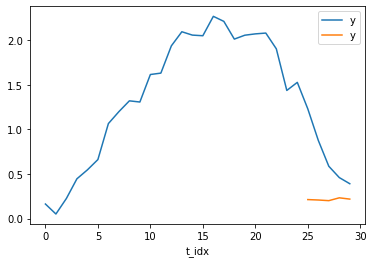

In [13]:
ax = new_data.temporal_targets[predict_for_sample].plot()
counterfactual_outcomes[0].plot(ax=ax)